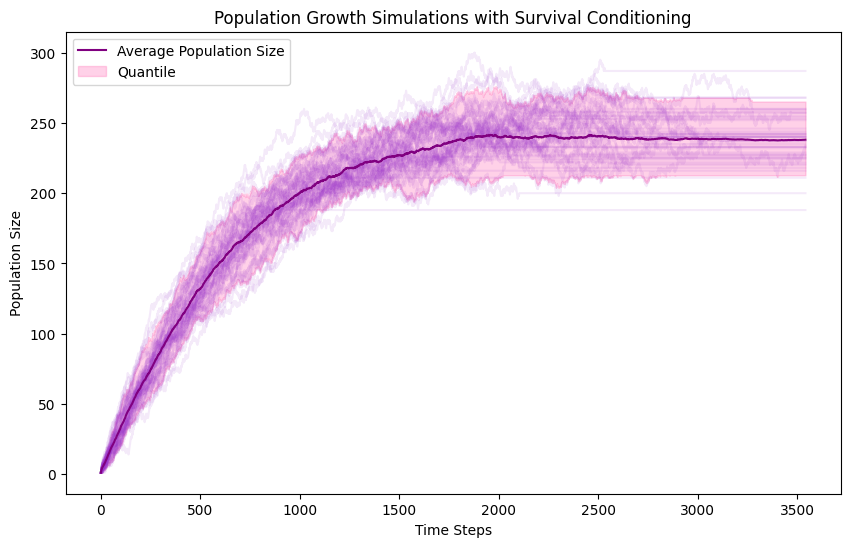

Extinction Probability: 0.52


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def set_parameters(initial_population, birth_rate, death_rate, survival_rate, carrying_capacity):
    return {
        "initial_population": initial_population,
        "birth_rate": birth_rate,
        "death_rate": death_rate,
        "survival_rate": survival_rate,
        "carrying_capacity": carrying_capacity
    }

def gillespie_simulation(params, max_time):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    carrying_capacity = params['carrying_capacity']
    
    time = 0
    time_points = [time]
    population_sizes = [population]

    while time < max_time and population > 0:
        birth_propensity = birth_rate * population * (1 - population / carrying_capacity)
        death_propensity = death_rate * population
        total_propensity = birth_propensity + death_propensity
        
        if total_propensity == 0:
            break
        
        # Time to next event
        time_to_next_event = np.random.exponential(1 / total_propensity)
        time += time_to_next_event
        
        # Determine which event occurs
        event_random = np.random.rand()
        if event_random < birth_propensity / total_propensity:
            population += 1  # Birth event
        else:
            population -= 1  # Death event
        
        time_points.append(time)
        population_sizes.append(population)
    
    return time_points, population_sizes

def run_multiple_simulations_with_quantiles(params, num_simulations=100, max_time=100):
    all_population_sizes = []
    max_steps = 0
    
    for _ in range(num_simulations):
        time_points, population_sizes = gillespie_simulation(params, max_time)
        if population_sizes[-1] > 0:  # Only include non-extinct populations
            max_steps = max(max_steps, len(time_points))
            all_population_sizes.append(population_sizes)
    
    all_population_sizes = np.array([np.pad(pop, (0, max_steps - len(pop)), 'edge') for pop in all_population_sizes])
    average_population_sizes = np.mean(all_population_sizes, axis=0)
    lower_quantile = np.quantile(all_population_sizes, 0.05, axis=0)
    upper_quantile = np.quantile(all_population_sizes, 0.95, axis=0)
    
    extinction_probability = 1 - len(all_population_sizes) / num_simulations
    
    return list(range(max_steps)), all_population_sizes, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

def plot_multiple_simulations_with_quantiles(time_points, all_population_sizes, average_population_sizes, lower_quantile, upper_quantile):
    plt.figure(figsize=(10, 6))
    
    for population_sizes in all_population_sizes:
        plt.plot(time_points, population_sizes, color='darkorchid', alpha=0.1)
    
    plt.plot(time_points, average_population_sizes, color='purple', label='Average Population Size')
    plt.fill_between(time_points, lower_quantile, upper_quantile, color='hotpink', alpha=0.3, label='Quantile')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Population Size')
    plt.legend()
    plt.title('Population Growth Simulations with Survival Conditioning')
    plt.show()

# Example usage
params = set_parameters(initial_population=1, birth_rate=0.2, death_rate=0.1, survival_rate=0.9, carrying_capacity=500)

num_simulations = 100
max_time = 100
all_time_points, all_population_sizes, average_population_sizes, lower_quantile, upper_quantile, extinction_probability = run_multiple_simulations_with_quantiles(params, num_simulations, max_time)

plot_multiple_simulations_with_quantiles(all_time_points, all_population_sizes, average_population_sizes, lower_quantile, upper_quantile)

print(f"Extinction Probability: {extinction_probability:.2f}")
